In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import joblib
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
# explicitly require this experimental feature
from sklearn.experimental import enable_halving_search_cv
# now you can import normally from model_selection
from sklearn.model_selection import HalvingGridSearchCV, RandomizedSearchCV,HalvingRandomSearchCV, GridSearchCV, cross_val_score

pd.options.display.max_rows = None



In [2]:
# Get path from training and test dataset

curr_path = os.getcwd()
dataset_src = os.path.join(curr_path, './dataset/dataset')
train_path = os.path.join(dataset_src, 'train.csv')
test_path = os.path.join(dataset_src, 'test.csv')


In [3]:
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

FileNotFoundError: [Errno 2] No such file or directory: '/home/seru/datascience-master/kaggle/PredictFuturesSales/dataset/train.csv'

In [ ]:
train_df.head()

Exploratory Analysis

In [ ]:
# Missing values?

train_df.info()



In [73]:
print(train_df.isnull().sum())
print('-----------')
print('-----------')
print(test_df.isnull().sum())

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64
-----------
-----------
PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64


In [84]:
print(train_df.Age.isnull().sum() / len(train_df))

0.020591280340503854


/tmp/ipykernel_10839/3223609532.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_df.Age.fillna(200))


<Axes: xlabel='Age', ylabel='Density'>

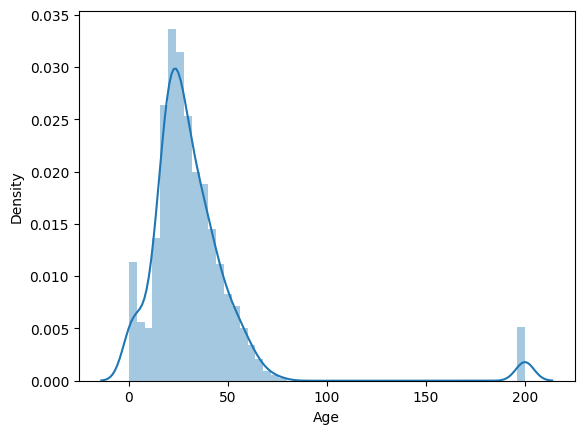

In [82]:
'''
Only 20% of the age data is missing. So, we need to fill the missing values. To do so, we can apply different methodologies:
- Take the mean of the age values
- Take random number with a normal law N(mean, std deviation) of the age
- Split the people in smaller group and then take the mean of these subgroups using categorical features - > the one I chose.
- Split the people in smaller group and then take random number with a normal law N(mean, std deviation) of the age within each subgroup

We'll use the third one.
'''

sns.distplot(train_df.Age.fillna(200))

In [85]:
list_features = test_df.columns
print('They are',len(list_features),'features in the dataset.')
print('----------------')
for f in list_features:
    print('feature:', f, '|| Type:', type(train_df[f][0]), '|| Example:', train_df[f][0], '|| number of unique values', len(train_df[f].unique()) )

They are 13 features in the dataset.
----------------
feature: PassengerId || Type: <class 'str'> || Example: 0001_01 || number of unique values 8693
feature: HomePlanet || Type: <class 'str'> || Example: Europa || number of unique values 4
feature: CryoSleep || Type: <class 'bool'> || Example: False || number of unique values 3
feature: Cabin || Type: <class 'str'> || Example: B/0/P || number of unique values 6561
feature: Destination || Type: <class 'str'> || Example: TRAPPIST-1e || number of unique values 4
feature: Age || Type: <class 'numpy.float64'> || Example: 39.0 || number of unique values 81
feature: VIP || Type: <class 'bool'> || Example: False || number of unique values 3
feature: RoomService || Type: <class 'numpy.float64'> || Example: 0.0 || number of unique values 1274
feature: FoodCourt || Type: <class 'numpy.float64'> || Example: 0.0 || number of unique values 1508
feature: ShoppingMall || Type: <class 'numpy.float64'> || Example: 0.0 || number of unique values 1116
fe

In [ ]:
# Define function that creates missing value heatmap

def plot_missing_data(dataset, title, figsize=(5,5)):
    """
    This function plots a heatmap of the missing values in the dataset.
    
    Parameters:
    dataset (pd.DataFrame): The dataset to be plotted.
    title (str): The title of the plot.
    figsize (tuple): The size of the figure (optional).
    """
    # Error handling
    if not isinstance(dataset, pd.DataFrame):
        raise ValueError("dataset must be a pandas DataFrame")
    if not isinstance(title, str):
        raise ValueError("title must be a string")
    
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(title)
    sns.heatmap(dataset.isnull(), cbar=False)

# Usage
plot_missing_data(train_df, 'Training Dataset', figsize=(15,7))


# def plot_missing_data(dataset, title):
#     fig, ax = plt.subplots(figsize=(5,5))
#     plt.title(title)
#     sns.heatmap(dataset.isnull(), cbar=False)

# plot_missing_data(train_df, 'Training Dataset')

# From the above plots, it can be seen that the training and similarly the test datasets contain features with missing values. The sparsest features are “age” and “cabin”.

# A naive approach to solve this problem would be to remove the feature completely from the dataset. 
# However, since we do not know how much information these they provide they further investigation is needed. 
# Maybe we find that it would make sense to impute the missing values using sophisticated data imputation methods.

In [7]:
# Question 1: How many passengers transported?

train_df['Transported'].value_counts()


Transported
True     4378
False    4315
Name: count, dtype: int64

In [60]:

train_df['Transported'].value_counts(normalize=True)

Transported
True     0.503624
False    0.496376
Name: proportion, dtype: float64

In [61]:
print(train_df.columns)
print('number of features', len(train_df.columns))
print(len(train_df), 'records for the training dataset.', '\n')
print(test_df.columns)
print('number of features', len(test_df.columns))
print(len(test_df), 'records for the testing dataset. ')


Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')
number of features 14
8693 records for the training dataset. 

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name'],
      dtype='object')
number of features 13
4277 records for the testing dataset. 


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [ ]:
def bar_chart_stacked(dataset, feature, stacked=True, figsize=(5,5)):
    """
    This function plots a stacked bar chart of the feature in the dataset.
    
    Parameters:
    dataset (pd.DataFrame): The dataset to be plotted.
    feature (str): The feature in the dataset to be plotted.
    stacked (bool): Whether the bar chart should be stacked.
    figsize (tuple): The size of the figure (optional).
    """
    # Error handling
    if not isinstance(dataset, pd.DataFrame):
        raise ValueError("dataset must be a pandas DataFrame")
    if not isinstance(feature, str):
        raise ValueError("feature must be a string")
    
    transported = dataset[dataset['Transported']==1][feature].value_counts()
    not_transported = dataset[dataset['Transported']==0][feature].value_counts()
    df_transported_not_transported = pd.DataFrame([transported, not_transported])
    df_transported_not_transported.index = ['Passengers Transported', 'Passengers not Transported']
    ax = df_transported_not_transported.plot(kind='bar', stacked=stacked, figsize=figsize)

# Usage
bar_chart_stacked(train_df, 'Transported', figsize=(10,5))


In [ ]:
#  Question 2: Is dependent of the HomePlanet?
# train_df.head(10)
train_df['HomePlanet'].value_counts().to_frame()

In [ ]:
def print_transported_ratio(dataset, feature):
    """
    This function prints the mean transported ratio for the given feature in the dataset.
    
    Parameters:
    dataset (pd.DataFrame): The dataset to be analyzed.
    feature (str): The feature in the dataset to be analyzed.
    """
    # Error handling
    if not isinstance(dataset, pd.DataFrame):
        raise ValueError("dataset must be a pandas DataFrame")
    if not isinstance(feature, str):
        raise ValueError("feature must be a string")
    
    # Calculate and print the transported ratio
    transported_ratio = dataset.groupby(feature).Transported.mean()
    print(f"Transported ratio based on {feature}:\n{transported_ratio}\n")

# Usage
print_transported_ratio(train_df, 'HomePlanet')
print_transported_ratio(train_df, 'VIP')
print_transported_ratio(train_df, 'CryoSleep')
print_transported_ratio(train_df, 'Destination')


In [ ]:
def bar_chart_stacked(dataset, features, stacked=True, figsize=(5,5)):
    """
    This function plots a stacked bar chart of the features in the dataset.
    
    Parameters:
    dataset (pd.DataFrame): The dataset to be plotted.
    features (list): The list of features in the dataset to be plotted.
    stacked (bool): Whether the bar chart should be stacked.
    figsize (tuple): The size of the figure (optional).
    """
    # Error handling
    if not isinstance(dataset, pd.DataFrame):
        raise ValueError("dataset must be a pandas DataFrame")
    if not isinstance(features, list):
        raise ValueError("features must be a list of strings")
    
    for feature in features:
        transported = dataset[dataset['Transported']==1][feature].value_counts()
        not_transported = dataset[dataset['Transported']==0][feature].value_counts()
        df_transported_not_transported = pd.DataFrame([transported, not_transported])
        df_transported_not_transported.index = ['Passengers Transported', 'Passengers not Transported']
        ax = df_transported_not_transported.plot(kind='bar', stacked=stacked, figsize=figsize)
        plt.title(f"Transported ratio based on {feature}")
        plt.show()

# Usage
features = ['VIP', 'HomePlanet', 'CryoSleep', 'Destination']
bar_chart_stacked(train_df, features, figsize=(10,10))


In [ ]:
print(train_df.head())

In [ ]:

# Passenger count with respect to HomePlanet
print(pd.pivot_table(train_df, index= 'Transported', columns = 'HomePlanet', values= 'Destination', aggfunc = 'count'), '\n'
)
# Passenger count with respect to Destination
# print(pd.pivot_table(train_df, index= 'Transported', columns = 'Destination', values= 'Destination', aggfunc = 'count'), '\n'
# )
# Passenger count with respect to VIP
# print(pd.pivot_table(train_df, index= 'Transported', columns = 'VIP', values= 'Destination', aggfunc = 'count'), '\n'
# )

# Passenger count with respect to CryoSleep
# print(pd.pivot_table(train_df, index= 'Transported', columns = 'CryoSleep', values= 'Destination', aggfunc = 'count'), '\n'
# )




In [ ]:
# Passenger HomePlanet distribution
print(train_df.groupby(['HomePlanet']).Transported.mean().to_frame())

# Passenger Destination distribution
print(train_df.groupby(['Destination']).Transported.mean().to_frame())

# Passenger VIP distribution
print(train_df.groupby(['VIP']).Transported.mean().to_frame())

# Passenger CryoSleep distribution
print(train_df.groupby(['CryoSleep']).Transported.mean().to_frame())



In [ ]:
'''
Key observations:

Most passenger had class 3 tickets, yet only 24% of class 3 passengers survived.
Almost 63% of the passenger from class 1 survived.
Approx 50% of the class 2 passenger survived.
'''

In [ ]:
# Question 4: Is the higher survival rate in Class 1 due to the class itself or due to a skewed gender distribution in which female passengers dominate?

# Function that plots bar chart with multiple features

def bar_chart_compare(dataset, feature1, feature2=None):
    plt.figure(figsize=[5,5])
    plt.title('Survival rate sex and class')
    g = sns.barplot(x=feature1, y='Survived', hue=feature2, ci=None, data=dataset).set_ylabel('Survival rate')

In [ ]:
# Percentage of male and female survivors with respect to gender

train_df.groupby(['Pclass', 'Sex']).Survived.mean().to_frame()

In [ ]:
'''
Key observations:

Survival Rate females 1. Class: 96,8%
Survival Rate females 2. Class: 92,1%
Survival Rate females 3. Class: 50%
Survival Rate male 1. Class: 36.8%
(still significantly lower than 3. class females)
'''

In [ ]:
# Question 5: Did a passengers age influence the chance of survival?

# Utility function for plotting a histogram and the kernel density estimate

def plot_distribution(dataset, feature, title, bins = 30, hist = True, fsize = (5,5)):
    fig, ax = plt.subplots(figsize=fsize)
    ax.set_title(title)
    sns.distplot(train_df[feature], color='g', bins=bins, ax=ax)
    # sns.histplot(train_df[feature], color='g', bins=bins, ax=ax, kde=True, stat="density", kde_kws=dict(cut=3))


def plot_kernel_density_estimate_survivors(dataset, feature1, title, fsize = (5,5)):
    fig, ax = plt.subplots(figsize=fsize)
    ax.set_title(title)
    sns.kdeplot(dataset[feature1].loc[train_df['Survived'] == 1],
                shade = True, ax=ax, label='Survived').set_xlabel(feature1)
    sns.kdeplot(dataset[feature1].loc[train_df['Survived'] == 0],
                shade = True, ax=ax, label='Died')
  


In [ ]:
# Age distribution

plot_distribution(train_df, 'Age', 'Age Distribution Passengers')

In [ ]:
# Age kernel density
plot_kernel_density_estimate_survivors(train_df, 'Age', 'Age Distribution Survived vs Died')

In [ ]:
# Function for creating a swarm plot

def plot_swarm_survivors(dataset, feature1, feature2, title, fsize = (155)):
    fig, ax = plt.subplots(figsize=(18,5))
    # Turns off grid on the left Axis
    ax.grid(True)
    plt.xticks(list(range(0,100,2)))
    sns.swarmplot(y=feature1, x=feature2, hue='Survived', data=train_df).set_title(title)

In [ ]:
# Age vs Sex swarm plot

plot_swarm_survivors(train_df, "Sex", "Age", "Survivor Swarmplot for Age and Gender")

# Looking at the results we can see that age holds valuable information. 
# The swarm plot above shows that a big portion of male survivors are passengers between 0 and 12 years of age. 
# It’s also interesting to see that the oldest passenger, a 80 year old man survived.

# Looking at the swarm plot below we can see how important the Pclass is when it comes to predicting the likelihood of survival. 
# One additional piece of information from the swarm plot below is that the first-class did not have a lot of children. 
# Maybe rich people get fewer kids in general?

In [ ]:
plot_swarm_survivors(train_df, "Age", "Pclass", "Survivor Swarmplot for Age and Gender")

In [ ]:
# Question 6: Did paying the ticket price influence the chance of survival?

train_df.Fare.describe()

In [ ]:
# Fare distribution


plot_distribution(train_df, "Fare", "Fare Distribution Passengers")

'''
Fare does not follow a normal distribution and has a huge spike at the price range [0–100$].

The distribution is skewed to the right with 75% of the fare paid under 31% and a max paid fare of 512$. 
Depending on the model that I’m going to use it might make sense to normalize this feature. However, 
this aspect will be tackled later in the feature engineering section.

To better understand how this feature influences the survival rate, we could plot bar plots of Fare vs Survived. 
Due to the large range of fares such as plot would not be useful for inferring useful information. 
A better suited visualization would be to combine fares into categories and then plot the categories vs Survived.

Categorising a continuous numerical feature is called binning and it’s a commonly used feature engineering technique . 
As usual sometimes it helps your model and sometimes it does not. 
That’s the cool part about Machine Learning, there is no clear cut answer and doing good experiments will lead you towards the right direction.
'''

In [ ]:
# Function to create a categorical fare feature of 4 distinct categories
def plot_quartiles(dataset, feature, title, categories):
    fig, axarr = plt.subplots(figsize=(5,5))
    fare_ranges = pd.qcut(dataset[feature], len(categories), labels = categories)  #[0, .25, .5, .75, 1]
    axarr.set_title(title)
    sns.barplot(x=fare_ranges, y=dataset.Survived, ci=None, ax=axarr).set_ylabel('Survival rate')

In [ ]:
# Bar plot fare categories

categories = ['Cheap', 'Standard', 'Expensive', 'Luxury']

plot_quartiles(train_df, 'Fare', 'Survival Rate by Fare Ranges/Categories', categories)

In [ ]:
'''
Key observations:

Cheap (0–25% of max Price): Surival Rate = 0.2 (approx)
Standard (25%-50% of max Price): Surival Rate = 0.3 (approx)
Expensive (50%-75% of max Price): Surival Rate = 0.45 (approx)
Luxury (75%-100% of max Price): Surival Rate = 0.55 (approx)
'''

In [ ]:
# Age vs Sex swarm plot

plot_swarm_survivors(train_df, 'Fare', 'Sex', 'Survivor Swarmplot for Age and Gender')

In [ ]:
'''
Key observations:

Irrespective of gender all passengers with a fare above 500$ survived.
All male passenger that paid between 200–300$ died
All female passenger that paid between 200–300$ survived
'''

In [ ]:
'''
This could be potentially be a pattern a classifier might pick up. 
One thing that caught my attention is that the minimum fare paid was 0.0 $. 
This seems highly unlikely.

We can investigate who these people were:
'''

train_df.loc[train_df.Fare==0]

In [ ]:
# Code to replace zero fare values with NaN’s
train_df.loc[train_df['Fare'] == 0, 'Fare'] = np.NaN
test_df.loc[test_df['Fare'] == 0, 'Fare'] = np.NaN


In [ ]:
# Question 8: Could the place of embarkation influence the chance of survival?
'''
My reasoning and intuition would not make me believe that the place of embarkation matters at all, however, we must dedicate ourselves to not make assumptions about the data.

One approach to analyze this is to use count plots for the 3 different locations of embarkation Southampton, Cherbourg and Queenstown:
'''

def show_countplot(dataset, feature, title, fsize = (5,5)):
    fig, ax = plt.subplots(figsize=fsize)
    sns.countplot(dataset[feature], ax=ax).set_title(title)

def show_compare_countplot(dataset, feature1, feature2, title):
    fig, ax = plt.subplots(figsize=(5,5))
    p = sns.countplot(x = feature1, hue=feature2, data=dataset, ax=ax).set_title(title)

In [ ]:
# Stackes bar plots for Embarked

bar_chart_stacked(train_df, 'Embarked')

In [ ]:

show_countplot(train_df, 'Embarked', 'Passengers count by boarding point')


In [ ]:
# Count of passengers with respect to place of embarktion

train_df['Embarked'].value_counts().to_frame()

In [ ]:
# Question 9: Was the high number of survivors that embarked at Cherbourg due to a high number of 1. Class passengers?

# Count plot for number of survivors with respect to place of embarktion and class

show_compare_countplot(train_df, 'Embarked', 'Pclass', 'Passengers count by place of embarktion and class')


In [ ]:
# Count for number of survivors with respect to place of embarktion and class

train_df.groupby(['Embarked', 'Pclass']).Survived.sum().to_frame()

In [ ]:
'''
The hypothesis seems to be correct.

The majority embarked at Cherbourg were 1. class passengers.
The majority embarked at Southampton were 3. class passengers.
However, it does not explain why the survival rate for Queenstown passengers is slightly higher than at Southampton even though the number of 1. class passenger in relation to 3. class passengers is higher for Southampton.

One explanation might be that the ratio between male and female passengers differs.
'''

In [ ]:
# Question 10: Is gender distribution responsible for the slightly higher passenger survival rate in Queenstown compared to Southampton?

# Passenger count by class and place of embarktion

show_compare_countplot(train_df, 'Embarked', 'Sex', 'Passenger count by place of embarktion and class')

In [ ]:
# Question 11: Does the number of children/siblings/spouses or parents on board influence the chance of survival?

# Count plot for survival rate vs SubSp

bar_chart_compare(train_df, "SibSp")

In [ ]:
# Count plot for SubSp

show_countplot(train_df, "SibSp", 'SibSp Distribution', (15,3))

In [ ]:
# Count plot for survival rate vs SubSp


show_compare_countplot(train_df, "SibSp", "Survived", "survived count by number of siblings / spouses aboard the Titanic")

In [ ]:
'''
As we can see from the plots above, the majority of passengers traveled alone. It seems that, the more siblings a passenger has the less chance of survival there is.

Parch:
'''

# Count plot for survival Parch
# show_countplot(train_df, "Parch Distribution", (15,3))

In [ ]:
'''
Similar to the SibSp column, this feature contains the number of parents or children each passenger was traveling with.
'''

# Count plot for survival rate vs Parch

bar_chart_compare(train_df, "Parch")


In [ ]:
# Count plot for survival rate vs Parch

show_compare_countplot(train_df, 'Parch', 'Survived', 'Survivor count by Parch')


In [ ]:
'''
Here we draw the same conclusions as for Parch as for SibSp. We can see again that small families had more chances to survive than bigger ones and passengers who traveled alone.

Later in the feature engineering part we will think about how to combine Parch and SibSp to a new feature that utilizes the information of both features.
'''

In [ ]:
'''
3. Feature Engineering
3.1 Feature Name:
One feature that we did not consider until now is the name. In theory, a person’s name should have no influence on the probability of survival, but on closer investigation we see that a title is sometimes hidden in the name, which in turn could be quite useful. However, using the different names as categorical variables does not make sense. One idea is to extract the title from the name.
'''

In [ ]:
# Sample titles
pd.unique(train_df['Name'])

In [ ]:
# Code to extract title from name

train_df['Title'] = train_df['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
test_df['Title'] = test_df['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())


In [ ]:
# Train dataframe sample titles after feature engineering
train_df.head()

In [ ]:
'''
If we now look at the count plot of the new title feature we see that certain titles dominate.
'''

# Count plot for titles after feature engineering

show_countplot(train_df, "Title", 'Title Distribution', (15,3))

In [ ]:
# Count plot after grouping titles to frequent groups

show_countplot(train_df, "Title", "Title Distribution after substitution", (15,3))

In [ ]:
'''
Finally, let’s investigate the title feature and the survival rate together
'''
# Bar plot surival rate vs title

# bar_chart_compare(train_df, 'Title', 'Title Distribution after substitution')

In [ ]:
'''
Key observations:

Female titles result in a higher survival rate.
Master and Dr have a surprisingly high survival rate even tough both are male titles.
Being “just” a Mr results in a bad survival rate of approx 15%
All 6 revenants died. Maybe they decided to accept their destiny and wanted to die with dignity.
'''

In [ ]:
# Feature Cabin and Ticket:

train_df[['Cabin', 'Ticket']].head()

In [ ]:
'''
As we can see both features are not easy to deal with. Cabin contains a lot of NaN’s and the ticket seems not to provide any useful information.

We can try different ideas:

Extract two leading letters to create a new feature
Extract number of letter in ticket to create a new features
Extract number of cabins used
Extract Cabin letter
'''

In [ ]:
# Ticket and Cabin engineered new features that could be tried out using experiments

# Extract Leading Letter:
train_df['Ticket_2letter'] = train_df.Ticket.apply(lambda x: x[:2])
test_df['Ticket_2letter'] = test_df.Ticket.apply(lambda x: x[:2])

In [ ]:
# Extract Ticket lenght:
train_df['Ticket_len'] = train_df.Ticket.apply(lambda x: len(x))
test_df['Ticket_len'] = test_df.Ticket.apply(lambda x: len(x))



In [ ]:
# Extract Number of Cabins:
train_df['Cabin_num'] = train_df.Ticket.apply(lambda x: len(x.split()))
test_df['Cabin_num'] = test_df.Ticket.apply(lambda x: len(x.split()))

In [ ]:
# Extract cabin Leading Letter:
train_df['Cabin_1letter'] = train_df.Ticket.apply(lambda x: x[:1])
test_df['Cabin_1letter'] = test_df.Ticket.apply(lambda x: x[:1])

In [ ]:
'''
Feature Family Size:
As mentioned in section 2.11, Parch and SibSp can be combined to a new feature to capture the information of both. We can calculate the size of the family by arithmetically adding both features:
'''

In [ ]:
train_df['Fam_size'] = train_df['SibSp'] + train_df['Parch'] + 1
test_df['Fam_size'] = test_df['SibSp'] + test_df['Parch'] + 1

In [ ]:
# Bar plot family size vs surival rate
bar_chart_compare(train_df, 'Fam_size')

In [ ]:
# Count plot family size vs survivors

show_compare_countplot(train_df, 'Fam_size', 'Survived', 'Survivor count by family size')

In [ ]:
# Feature Family Type:

# Creation of the groups
train_df['Fam_type'] = pd.cut(train_df.Fam_size, [0,1,4,7,11], labels=['Solo', 'Small', 'Big', 'Very big'])
test_df['Fam_type'] = pd.cut(test_df.Fam_size, [0,1,4,7,11], labels=['Solo', 'Small', 'Big', 'Very big'])

# Bar plot survival rate vs family type
bar_chart_compare(train_df, 'Fam_type')


In [ ]:
'''
In a similar way we can create a new categorical feature that encodes the family size into 4 distinct groups.
'''

In [ ]:
'''
Training a Classifier
Although we have a relatively large number of features available in relation to the size of the dataset, it does not necessarily make sense to use all of them (See discussion in section 2)

We start by selecting the features we will use and isolating the target:

‘Pclass’, ‘Fare’, ‘Title’, ‘Embarked’, ‘Fam_type’, ‘Ticket_len’, ‘Ticket_2letter’
Cabin will not be used and the relevant information about the feature age (which is being a young man) is already encoded in the title feature
Sex will not be used to not confuse the classifier as adult males and young boys the same sex but are really different categories
'''

In [ ]:
# Final train dataframe
y = train_df['Survived']
features = ['Pclass', "Fare", 'Title', 'Embarked', 'Fam_type', 'Ticket_len', 'Ticket_2letter']
X = train_df[features]
X.head()

In [ ]:
'''
The last step before fitting a model is to prepare a pipeline that will make sure that all the preprocessing performed on the training data is also done on the test data:
'''

In [ ]:
numerical_cols = ['Fare']
categorical_cols = ['Pclass', 'Title', 'Embarked', 'Fam_type', 'Ticket_len', 'Ticket_2letter']

# Inputing numerical vales with median
numerical_transformer = SimpleImputer(strategy='median')

# Inputing missing values with most frequent one for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocesor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
])


# Bundle preprocessing and modeling code
titanic_pipeline = Pipeline(steps=[
    ('preprocessor', preprocesor),
    ('model', GradientBoostingClassifier(random_state=0))
])


param_grid = {
            'model__learning_rate': [0.01, 0.02, 0.03],
            'model__subsample': [0.1, 0.2, 0.3],
            'model__n_estimators': [50, 100, 200, 500],
            'model__max_depth': [4, 6, 9, 12],
            
        }


grid_search = GridSearchCV(titanic_pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=3)

grid_search.fit(X, y)



# Display more information during execution
print(f'Best Accuracy: {grid_search.best_score_}')
print('Best Parameters:', grid_search.best_params_)

# Get detailed classification report
X_test = test_df[features]
y_pred = grid_search.predict(X_test)






In [ ]:
output = pd.DataFrame({'PassengerId': test_df.PassengerId, 'Survived': y_pred })
output.to_csv(f'submission_{grid_search.best_score_}_LR.csv', index=False)
print('Your submission was successfully saved!')